# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


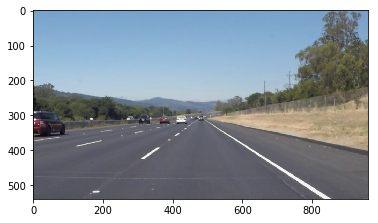

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            ratio = (x2-x1) / (y2-y1)
            if (y2>y1):
                x1 = round_int(x1+(0-y1)*ratio)
                y1 = 0
                
                x2 = round_int(x2+(540-y2)*ratio)
                y2 = 540
            else :
                x2 = round_int(x2+(0-y2)*ratio)
                y2 = 0
                
                x1 = round_int(x1+(540-y1)*ratio)
                y1 = 540
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):

    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if ( lines == None ) :
        print('none')
    else: 
        draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    `initial_img` should be the image before any processing.
    The result image is computed as follows:
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def round_int(x):
    if x == float("inf") or x == float("-inf"):
        return 960 # or x or return whatever makes sense
    return int(round(x))

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidYellowLeft.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteCurve.jpg',
 'whiteCarLaneSwitch.jpg']

# STEP1 select by Color and cut the Region of interest

`red_threshold = green_threshold = blue_threshold = 200`

**select the white line in the photo**

cut the ROI twice


**1. use the region in blue triangle**

**2. use the region under the red line**

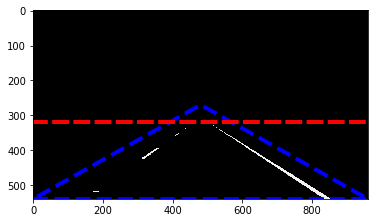

In [5]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')
ysize = image.shape[0]
xsize = image.shape[1]
color_select = np.copy(image)
line_image = np.copy(image)
red_threshold = green_threshold = blue_threshold = 200
rgb_threshold = [red_threshold, green_threshold, blue_threshold]



left_bottom = [0, 540]
right_bottom = [960, 540]
apex = [480, 270]
fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

top_left = [0,320]
top_right = [960,320]
fit_top = np.polyfit((top_left[0], top_right[0]), (top_left[1], top_right[1]), 1)

color_thresholds = (image[:,:,0] < rgb_threshold[0]) | \
                    (image[:,:,1] < rgb_threshold[1]) | \
                    (image[:,:,2] < rgb_threshold[2])
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1])) & \
                    (YY > (XX*fit_top[0] + fit_top[1]))

color_select[color_thresholds | ~region_thresholds] = [0, 0, 0]
line_image[~color_thresholds & region_thresholds] = [255, 0, 0]



x = [left_bottom[0], right_bottom[0], apex[0], left_bottom[0]]
y = [left_bottom[1], right_bottom[1], apex[1], left_bottom[1]]
plt.plot(x, y, 'b--', lw=4)# blue triangle
xc = [top_left[0], top_right[0], top_left[0]]
yc = [top_left[1], top_right[1], top_left[1]]

plt.plot(xc, yc, 'r--', lw=4)# red range
#plt.imshow(image)# color image
plt.imshow(color_select)  #the red line
#plt.imshow(line_image)

# 1-1 gaussian_blur

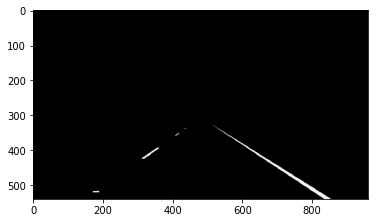

In [6]:
gimg = gaussian_blur(color_select,5)
plt.imshow(gimg)  #the red line

# STEP2 extend the line by Canny and hough_lines

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:69: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


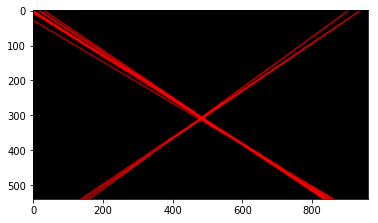

In [7]:
# Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(gimg, low_threshold, high_threshold)
mask = np.zeros_like(edges)   
ignore_mask_color = 255   
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(0, 0), (imshape[1], 0), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)
rho = 2 #distance resolution in pixels of the Hough grid
theta = np.pi/180 #angular resolution in radians of the Hough grid
threshold = 15     #minimum number of votes (intersections in Hough grid cell)
min_line_len = 40 #minimum number of pixels making up a line
max_line_gap = 20    #maximum gap in pixels between connectable line segments
line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
line_img = gaussian_blur(line_img,5)
line_img = gaussian_blur(line_img,5)

plt.imshow(line_img)  #the red line


# 2-1 select the ROI again

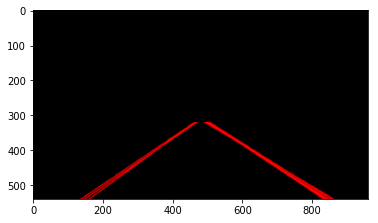

In [8]:
line_img[~region_thresholds] = [0, 0, 0]
plt.imshow(line_img)  #the red line

# STEP3 cover with the origin image 

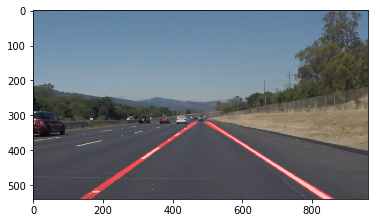

In [9]:

wimg =  weighted_img(line_img, image, α=0.8, β=1., γ=0.)
plt.imshow(wimg)  #the red line

## Test on Videos



In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [11]:
import imageio
imageio.plugins.ffmpeg.download()

# Rewrite the process as a function

In [12]:
def process_image(image):
    ysize = image.shape[0]
    xsize = image.shape[1]
    color_select = np.copy(image)
    line_image = np.copy(image)
    red_threshold = green_threshold = 200
    blue_threshold = 0
    rgb_threshold = [red_threshold, green_threshold, blue_threshold]
    left_bottom = [0, 540]
    right_bottom = [960, 540]
    apex = [480, 270]
    fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
    fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
    fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)
    top_left = [0,360]
    top_right = [960,360]
    fit_top = np.polyfit((top_left[0], top_right[0]), (top_left[1], top_right[1]), 1)
    color_thresholds = (image[:,:,0] < rgb_threshold[0]) | \
                        (image[:,:,1] < rgb_threshold[1]) | \
                        (image[:,:,2] < rgb_threshold[2])
    XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
    region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                        (YY > (XX*fit_right[0] + fit_right[1])) & \
                        (YY < (XX*fit_bottom[0] + fit_bottom[1])) & \
                        (YY > (XX*fit_top[0] + fit_top[1]))
    color_select[color_thresholds | ~region_thresholds] = [0, 0, 0]
    line_image[~color_thresholds & region_thresholds] = [255, 0, 0]
    x = [left_bottom[0], right_bottom[0], apex[0], left_bottom[0]]
    y = [left_bottom[1], right_bottom[1], apex[1], left_bottom[1]]
    xc = [top_left[0], top_right[0], top_left[0]]
    yc = [top_left[1], top_right[1], top_left[1]]
    gimg = gaussian_blur(color_select,5)
    low_threshold = 50
    high_threshold = 150
    
    edges = cv2.Canny(gimg, low_threshold, high_threshold)
    
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(0, 0), (imshape[1], 0), (imshape[1],imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_edges = cv2.bitwise_and(edges, mask)
    rho = 2 #distance resolution in pixels of the Hough grid
    theta = np.pi/180 #angular resolution in radians of the Hough grid
    threshold = 15     #minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40 #minimum number of pixels making up a line
    max_line_gap = 20    #maximum gap in pixels between connectable line segments
    line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    
    line_img[~region_thresholds] = [0, 0, 0]
    result =  weighted_img(line_img, image, α=0.8, β=1., γ=0.)
    return result

Let's try the one with the solid white lane on the right first ...

In [13]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:27<00:00,  7.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 15.5 s, sys: 1.47 s, total: 16.9 s
Wall time: 28.8 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [15]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


 99%|█████████▉| 125/126 [00:14<00:00,  7.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 8.63 s, sys: 1.03 s, total: 9.66 s
Wall time: 16.5 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [17]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


 34%|███▍      | 86/251 [00:17<00:42,  3.89it/s]

none


 47%|████▋     | 119/251 [00:26<00:35,  3.74it/s]

none


 48%|████▊     | 121/251 [00:26<00:35,  3.69it/s]

none


 49%|████▊     | 122/251 [00:26<00:34,  3.73it/s]

none


 49%|████▉     | 123/251 [00:27<00:34,  3.66it/s]

none


 52%|█████▏    | 130/251 [00:29<00:34,  3.52it/s]

none


 52%|█████▏    | 131/251 [00:29<00:32,  3.69it/s]

none


 53%|█████▎    | 132/251 [00:29<00:32,  3.64it/s]

none


 53%|█████▎    | 133/251 [00:29<00:32,  3.63it/s]

none


 53%|█████▎    | 134/251 [00:30<00:32,  3.63it/s]

none


 54%|█████▍    | 135/251 [00:30<00:31,  3.69it/s]

none


 54%|█████▍    | 136/251 [00:30<00:31,  3.64it/s]

none


 56%|█████▌    | 141/251 [00:32<00:28,  3.79it/s]

none


 57%|█████▋    | 142/251 [00:32<00:29,  3.74it/s]

none


 57%|█████▋    | 143/251 [00:32<00:28,  3.76it/s]

none


 57%|█████▋    | 144/251 [00:32<00:28,  3.70it/s]

none


 58%|█████▊    | 145/251 [00:33<00:28,  3.76it/s]

none


 58%|█████▊    | 146/251 [00:33<00:28,  3.72it/s]

none


 59%|█████▊    | 147/251 [00:33<00:28,  3.67it/s]

none


 59%|█████▉    | 148/251 [00:33<00:28,  3.61it/s]

none


 59%|█████▉    | 149/251 [00:34<00:29,  3.45it/s]

none


 60%|█████▉    | 150/251 [00:34<00:29,  3.47it/s]

none


 60%|██████    | 151/251 [00:34<00:27,  3.57it/s]

none


 61%|██████    | 152/251 [00:35<00:28,  3.44it/s]

none


 62%|██████▏   | 156/251 [00:36<00:26,  3.59it/s]

none


 63%|██████▎   | 157/251 [00:36<00:24,  3.80it/s]

none


 63%|██████▎   | 158/251 [00:36<00:24,  3.73it/s]

none


 63%|██████▎   | 159/251 [00:37<00:24,  3.78it/s]

none


 64%|██████▎   | 160/251 [00:37<00:24,  3.75it/s]

none


 65%|██████▌   | 164/251 [00:38<00:22,  3.81it/s]

none


 67%|██████▋   | 167/251 [00:39<00:22,  3.77it/s]

none


 67%|██████▋   | 168/251 [00:39<00:22,  3.71it/s]

none


100%|██████████| 251/251 [01:01<00:00,  3.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 31.9 s, sys: 3.09 s, total: 35 s
Wall time: 1min 5s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))